In [2]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, CuDNNLSTM, Flatten
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
import numpy as np
from numpy import pi
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


In [3]:


class Particle_Tracking_Training_Data(tf.Module):
    def __init__(self, Nt, rings=True):
        self.Nt = int(Nt)
        self.Ny = self.Nx = 256
        self.d = 3
        ximg = [[[i, j] for i in np.arange(self.Ny)]
            for j in np.arange(self.Nx)]
        self.ximg = np.float32(ximg)

        x = np.arange(self.Nx) - self.Nx//2
        y = np.arange(self.Ny) - self.Ny//2
        X0, Y0 = np.meshgrid(x, y)
        self.X = np.float32(X0)
        self.Y = np.float32(Y0)

        if rings:
            self.ring_indicator = 1.
        else:
            self.ring_indicator = 0.

        self._gen_video = tf.function(
            input_signature=(
                tf.TensorSpec(
                    shape=[self.Ny, self.Nx, self.Nt, None], dtype=tf.float32),
                tf.TensorSpec(shape=[self.Nt, None], dtype=tf.float32),
                tf.TensorSpec(shape=[], dtype=tf.float32),
                tf.TensorSpec(shape=[], dtype=tf.float32),
                tf.TensorSpec(shape=[], dtype=tf.float32),)
        )(self._gen_video)

        self._gen_labels = tf.function(
            input_signature=(
                tf.TensorSpec(
                    shape=[self.Ny, self.Nx, self.Nt, None], dtype=tf.float32),)
        )(self._gen_labels)

    def __call__(self, kappa, a, IbackLevel, Nparticles, sigma_motion):
        ## random brownian motion paths
        ## Nt, Nparticles, 3
        xi = self._sample_motion(Nparticles, sigma_motion)

        #### translate track positions to img coords
        ## Ny, Nx, Nt, Np, 2
        XALL = (self.ximg[:, :, None, None, :]
                - xi[None, None, :, :, :2])
        ## Ny, Nx, Nt, Np
        r = tf.math.sqrt(XALL[..., 0]**2 + XALL[..., 1]**2)
        z = xi[..., 2]

        ### generate video
        I = self._gen_video(r, z, kappa, a, IbackLevel)

        ### generate labels
        labels = self._gen_labels(r)

        return I, labels, xi

    @staticmethod
    def rand(n):
        return tf.random.uniform([n], dtype=tf.float32)

    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.float32),))
    def _sample_motion(self, Nparticles, sigma_motion):
        #### boundaries
        b_lower = tf.constant(
            [-10, -10, -30.], tf.float32)
        b_upper = tf.constant(
            [self.Nx+10, self.Ny+10, 30.], tf.float32)
        #### uniform random initial possitions
        U = tf.random.uniform(
            [1, Nparticles, self.d],
            dtype=tf.float32)
        X0 = b_lower + (b_upper - b_lower)*U
        #### normal increments
        dX = tf.random.normal(
            [self.Nt, Nparticles, self.d],
            stddev=sigma_motion,
            dtype=tf.float32)
        #### unbounded Brownian motion
        X = X0 + tf.math.cumsum(dX, axis=0)
        #### reflected brownian motion
        ## note that this is imperfect,
        ## if increments are very large it wont work
        X = tf.math.abs(X - b_lower) + b_lower
        X = -tf.math.abs(b_upper - X) + b_upper
        return X

    def _gen_video(self, r, z, kappa, a, IbackLevel):
        uw = (0.5 + self.rand(1))/2.
        un = tf.floor(3*self.rand(1))
        uampRing = 0.2 + 0.8*self.rand(1)
        ufade = 15 + 10*self.rand(1)
        rmax = ufade*(un/uw)**(2./3.)
        ufadeMax = 0.85
        fade = (1. - ufadeMax*tf.abs(tf.tanh(z/ufade)))
        core = tf.exp(-(r**2/(8.*a))**2)
        ring = fade*(tf.exp(-(r - z)**4/(a)**4)
                + 0.5*uampRing*tf.cast(r<z, tf.float32))
        I = tf.transpose(
            tf.reduce_sum(
                fade*(core + self.ring_indicator*ring),
                axis=3),
            [2, 0, 1]) # Nt, Ny, Nx
        I += IbackLevel*tf.sin(
            self.rand(1)*6*pi/512*tf.sqrt(
                self.rand(1)*(self.X - self.rand(1)*512)**2
                    + self.rand(1)*(self.Y - self.rand(1)*512)**2))
        I += tf.random.normal(
            [self.Nt, self.Ny, self.Nx],
            stddev=kappa,
            dtype=tf.float32)
        Imin = tf.reduce_min(I)
        Imax = tf.reduce_max(I)
        I = (I - Imin)/(Imax - Imin)
        I = tf.round(I*tf.maximum(256., tf.round(2**16*self.rand(1))))
        return I

    def _gen_labels(self, r):
        R_detect = 3.
        ## (Ny, Nx, Nt)
        detectors = tf.reduce_sum(
            tf.cast(r[::2, ::2, :, :] < R_detect, tf.int32),
            axis=3)
        ## (Nt, Ny, Nx)
        P = tf.transpose(
            tf.cast(detectors > 0, tf.int32), [2, 0, 1])
        ## (Nt, Ny, Nx, 2)
        labels = tf.stack([1-P, P], 3)
        return labels

In [4]:
Nt = 300 ## number of frames for each video
kappa = 0.1 ## standard deviation of background noise added to image
a = 3. ## scale factor for the size of particle spots (not true size of particles)
IbackLevel = 0.1 ## relative intensity of randomly generated background pattern; in (0, 1)
Nparticles = 3 ## the number of particles (more => slower)
sigma_motion = 2 ## the standard deviation for particle brownian motion; should be in (0, 10)


pt = Particle_Tracking_Training_Data(Nt) ## create object instance

vid, labels, tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion) 


## **Generating the Data**

In [7]:
@interact(t=(0, Nt-1, 1))
def plotfn(t=0):
    fig = figure(1, [14, 7])
    imshow(vid[t], origin='lower')
    #xlim(-10, 265)
    #ylim(-10, 265)

interactive(children=(IntSlider(value=0, description='t', max=299), Output()), _dom_classes=('widget-interact'…

## **Detecting the Particles**

In [5]:
@interact(t=(0, Nt-1, 1))
def plotfn(t=0, show_tracks=True):
    fig = figure(1, [14, 7])
    imshow(vid[t], origin='lower')
    if show_tracks:
        plot(tracks[t, :, 0], tracks[t, :, 1], 'rx')
    xlim(-10, 265)
    ylim(-10, 265)

interactive(children=(IntSlider(value=0, description='t', max=299), Checkbox(value=True, description='show_tra…

# **Tracking the Particles**

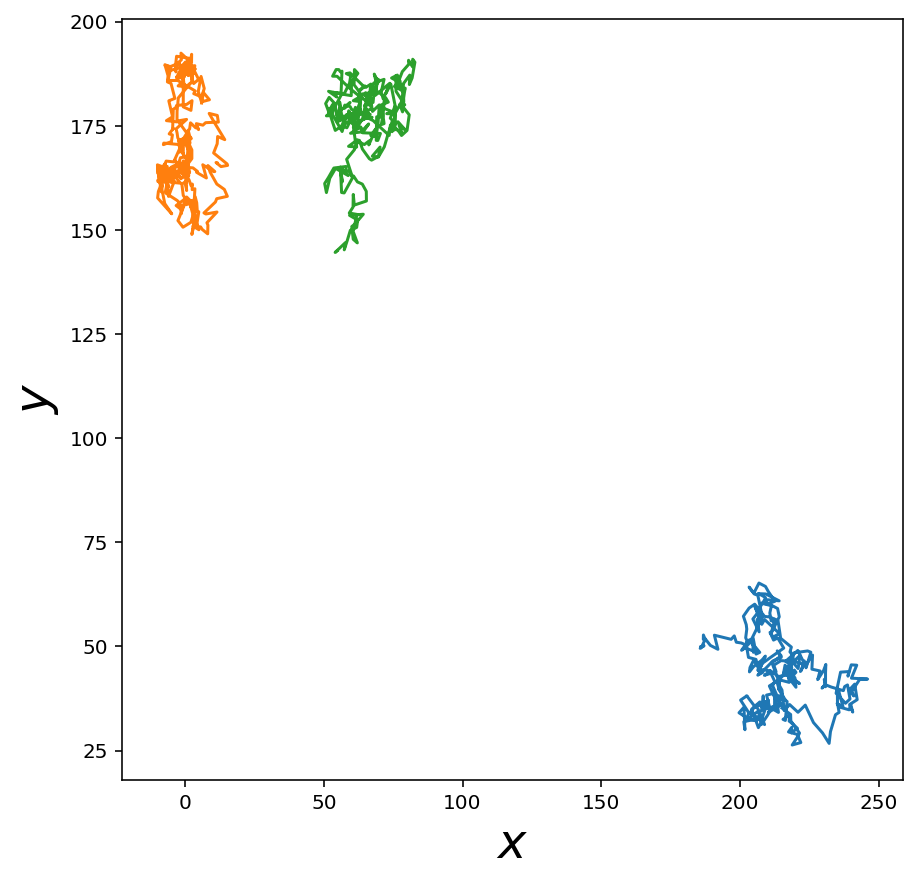

In [9]:
figure(1, [7, 7])
plot(tracks[..., 0], tracks[..., 1])
#xlim(-12, 300)
#ylim(-12, 300)
xlabel(r'$x$', fontsize=24)
ylabel(r'$y$', fontsize=24);

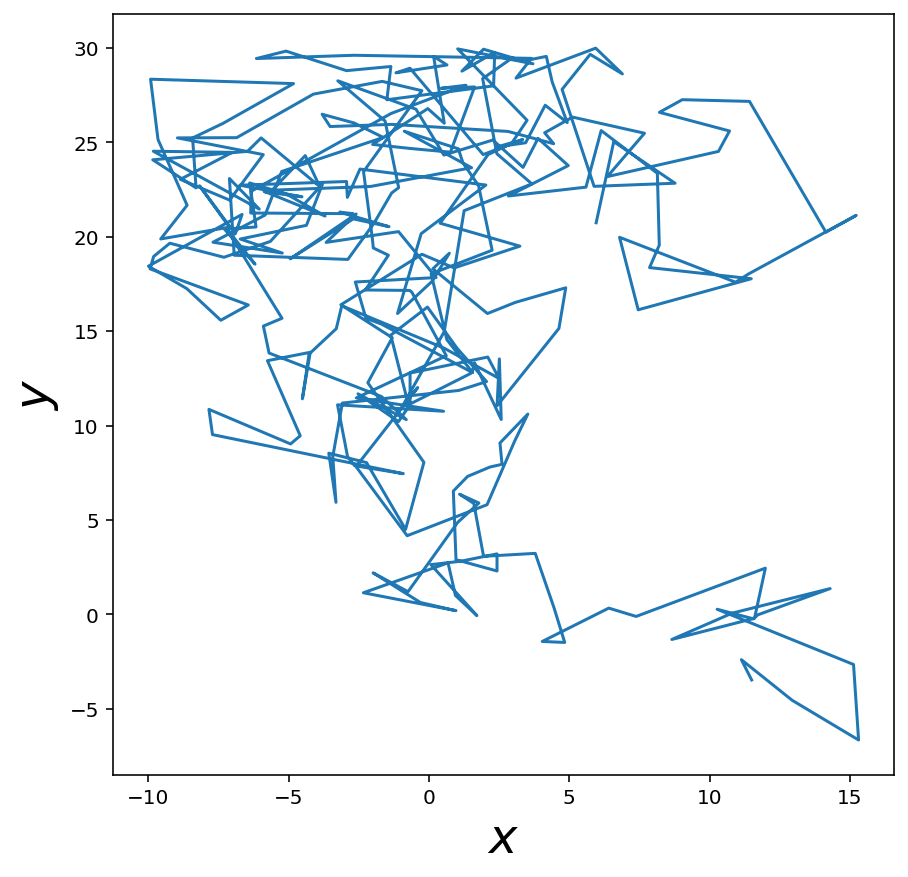

In [11]:
figure(1, [7, 7])
plot(tracks[:,1,0], tracks[:,1,2])
#xlim(-12, 300)
#ylim(-12, 300)
xlabel(r'$x$', fontsize=24)
ylabel(r'$y$', fontsize=24);

In [115]:
X=np.array(tracks[:,0,0])
X_scaled=(X-np.mean(X))/np.std(X)
Y=np.array(tracks[:,0,1])
Y_scaled=(Y-np.mean(Y))/np.std(Y)

In [169]:
def get_data(data):
    a_train=[]
    b_train=[]
    for i in range(10,len(data)):
        a_train.append(data[i-10:i])
        b_train.append(data[i])
    a_train, b_train = np.array(a_train), np.array(b_train)
    return(a_train, b_train)

In [170]:
X_train, y_train=get_data(X_scaled[:250])
X_test, y_test=get_data(X_scaled[250:])
Xy_train, yy_train=get_data(Y_scaled[:250])
Xy_test, yy_test=get_data(Y_scaled[250:])

In [247]:
X_train = []
y_train = []
X_train_scaled=X_scaled[:250]
#train_data=train_data.numpy()
for i in range(30,len(X_scaled)):
    X_train.append(X_scaled[i-30:i])
    y_train.append(X_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)

In [248]:
Xy_train = []
yy_train = []
Xy_train_scaled=Y_scaled[:250]
#train_data=train_data.numpy()


In [ ]:
X_test = []
y_test = []

for i in range(30,len(X_scaled)):
    X_train.append(X_scaled[i-30:i])
    y_train.append(X_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))



In [76]:
opt=tf.keras.optimizers.RMSprop(
    learning_rate=0.001
)
model = Sequential()
model.add(CuDNNLSTM(units=32,return_sequences=True, input_shape=(X_train.shape[1],1)))
#model.add(CuDNNLSTM(units=256,return_sequences=True))
#model.add(CuDNNLSTM(units=128,return_sequences=True))
#model.add(Dropout(0.2))
model.add(CuDNNLSTM(units=16,return_sequences=True))
#model.add(CuDNNLSTM(units=32,return_sequences=True))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(units=8,return_sequences=True))
#model.add(CuDNNLSTM(units=8,return_sequences=True))
model.add(CuDNNLSTM(units=4,return_sequences=True))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer=opt,loss='mean_squared_error',metrics=["mae"])


In [171]:
model=Sequential()
model.add(CuDNNLSTM(units=128,return_sequences=True, input_shape=(X_train.shape[1],1)) )
model.add(Dropout(0.2))
model.add(CuDNNLSTM(units=64,return_sequences=True) )
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=1))
# Compiling the RNN
model.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
#model.fit(X_train,y_train,epochs=50,batch_size=16)

In [172]:
model.fit(Xy_train,yy_train,epochs=50,batch_size=16,validation_data=(Xy_test[:2], yy_test[:2]))
y_pred = model.predict(Xy_test)

Epoch 1/50
15/15 [==============================] - 3s 51ms/step - loss: 0.3942 - val_loss: 0.0273
Epoch 2/50
15/15 [==============================] - 0s 17ms/step - loss: 0.2671 - val_loss: 0.0733
Epoch 3/50
15/15 [==============================] - 0s 14ms/step - loss: 0.2214 - val_loss: 0.0130
Epoch 4/50
15/15 [==============================] - 0s 15ms/step - loss: 0.2123 - val_loss: 0.0633
Epoch 5/50
15/15 [==============================] - 0s 14ms/step - loss: 0.2002 - val_loss: 0.0469
Epoch 6/50
15/15 [==============================] - 0s 14ms/step - loss: 0.1866 - val_loss: 0.0533
Epoch 7/50
15/15 [==============================] - 0s 14ms/step - loss: 0.1691 - val_loss: 0.1987
Epoch 8/50
15/15 [==============================] - 0s 14ms/step - loss: 0.1565 - val_loss: 0.1699
Epoch 9/50
15/15 [==============================] - 0s 14ms/step - loss: 0.1450 - val_loss: 0.0362
Epoch 10/50
15/15 [==============================] - 0s 14ms/step - loss: 0.1434 - val_loss: 0.0080
Epoch 11/

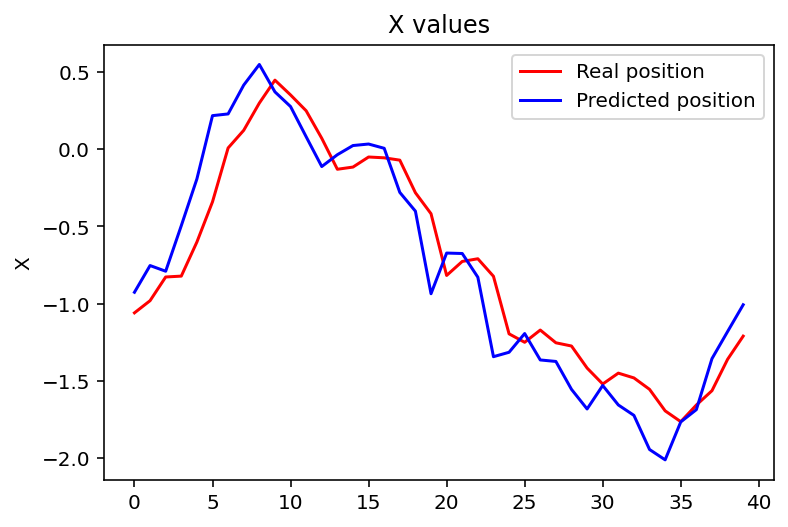

MSE =  0.23956507


In [173]:
plt.plot(y_pred, color='red',label='Real position')
plt.plot(yy_test, color='blue',label='Predicted position');
plt.title('X values')
#plt.xlabel('Date')
plt.ylabel('X')
plt.legend()
plt.show()

MSE1=mean_squared_error(y_pred, yy_test, squared=False)
print("MSE = ", MSE1)


In [174]:
model.fit(X_train,y_train,epochs=50,batch_size=16, validation_data=(X_test[:2], y_test[:2]))
x_pred = model.predict(X_test)

Epoch 1/50
15/15 [==============================] - 0s 20ms/step - loss: 0.0490 - val_loss: 0.0503
Epoch 2/50
15/15 [==============================] - 0s 14ms/step - loss: 0.0478 - val_loss: 0.0663
Epoch 3/50
15/15 [==============================] - 0s 14ms/step - loss: 0.0443 - val_loss: 0.0869
Epoch 4/50
15/15 [==============================] - 0s 14ms/step - loss: 0.0480 - val_loss: 0.0574
Epoch 5/50
15/15 [==============================] - 0s 14ms/step - loss: 0.0452 - val_loss: 0.0537
Epoch 6/50
15/15 [==============================] - 0s 15ms/step - loss: 0.0460 - val_loss: 0.0717
Epoch 7/50
15/15 [==============================] - 0s 14ms/step - loss: 0.0409 - val_loss: 0.0620
Epoch 8/50
15/15 [==============================] - 0s 14ms/step - loss: 0.0392 - val_loss: 0.0819
Epoch 9/50
15/15 [==============================] - 0s 14ms/step - loss: 0.0424 - val_loss: 0.0612
Epoch 10/50
15/15 [==============================] - 0s 14ms/step - loss: 0.0402 - val_loss: 0.0589
Epoch 11/

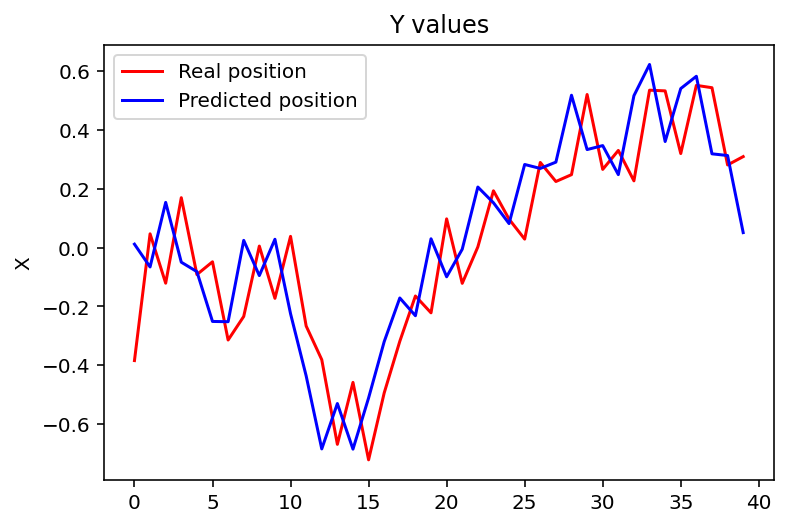

MSE =  0.190686


In [175]:
plt.plot(x_pred, color='red',label='Real position')
plt.plot(y_test, color='blue',label='Predicted position');
plt.title('Y values')
#plt.xlabel('Date')
plt.ylabel('X')
plt.legend()
plt.show()

MSE1=mean_squared_error(x_pred, y_test, squared=False)
print("MSE = ", MSE1)

In [139]:
x_pred

array([[ 0.02891346],
       [-0.25876385],
       [-0.09110858],
       [ 0.08409639],
       [-0.03282701],
       [-0.1471768 ],
       [ 0.1513299 ],
       [ 0.12525119],
       [ 0.06137033],
       [ 0.47542968],
       [ 0.11650269],
       [ 0.24012011],
       [ 0.12309794],
       [ 0.4640012 ],
       [ 0.4176118 ],
       [ 0.29948637],
       [ 0.4742349 ],
       [ 0.4235113 ],
       [ 0.16309182],
       [ 0.21584761]], dtype=float32)

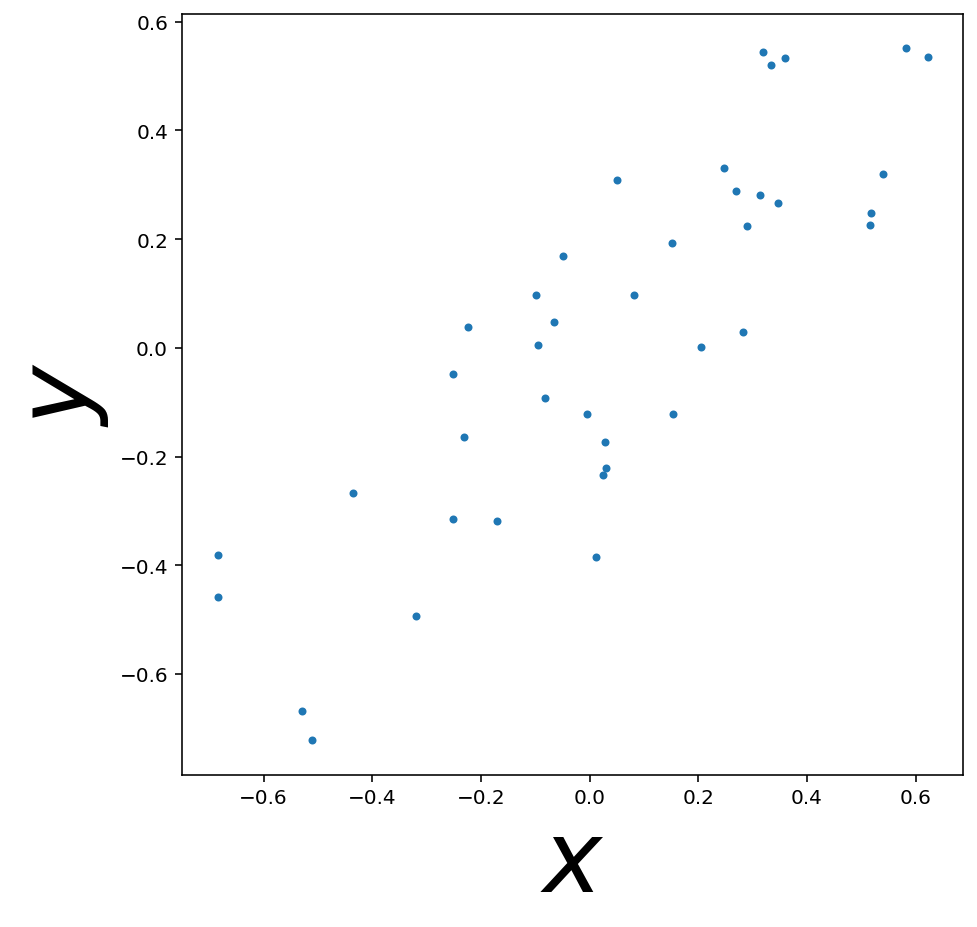

In [176]:
figure(1, [7, 7])
plot(y_test,x_pred,'.')
#xlim(50, 200)
#ylim(50, 200)


xlabel(r'$x$', fontsize=50)
ylabel(r'$y$', fontsize=50);

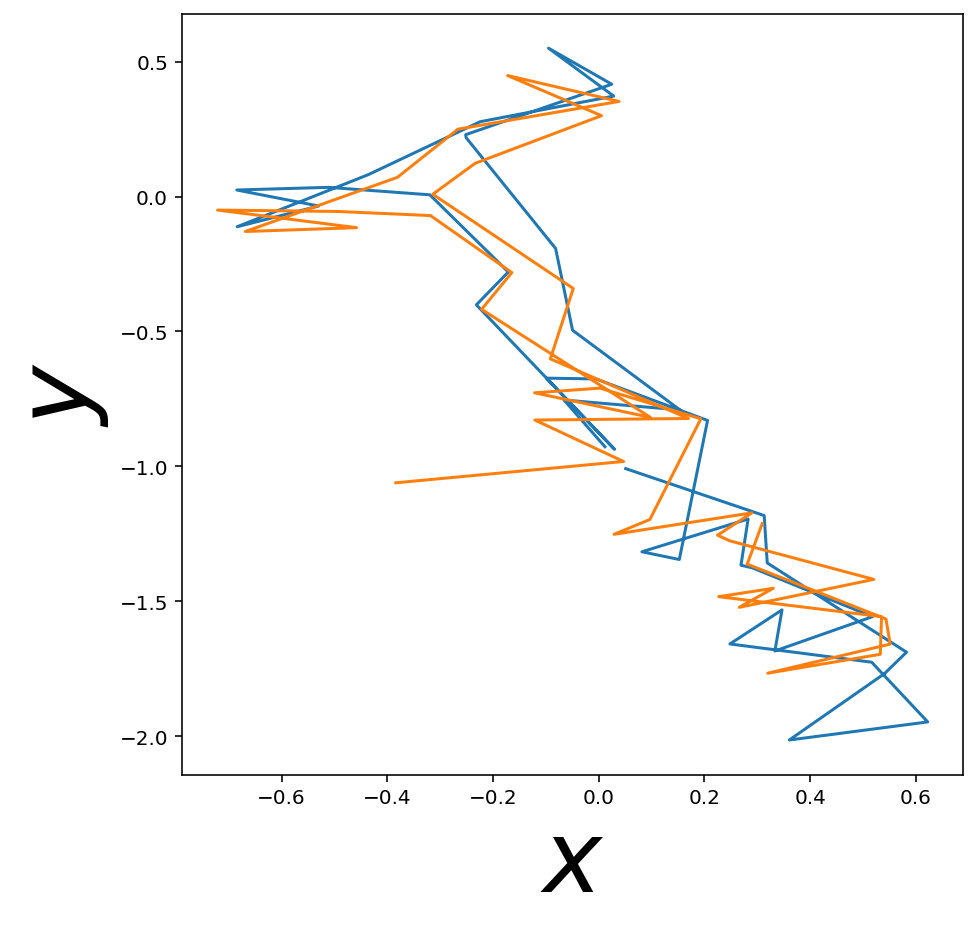

In [178]:
figure(1, [7, 7])
plot(y_test,yy_test)
#xlim(50, 200)
#ylim(50, 200)
plot(x_pred, y_pred)

xlabel(r'$x$', fontsize=50)
ylabel(r'$y$', fontsize=50);

In [227]:
tracks[250:,1,0]

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([140.36302, 140.77554, 142.66766, 143.36247, 138.62723, 139.49977,
       137.80324, 138.58437, 140.95016, 139.20639, 142.53313, 142.88295,
       143.422  , 144.35042, 144.1716 , 147.77264, 148.27075, 149.94284,
       149.1331 , 151.54823, 152.08319, 147.50658, 150.85767, 148.4269 ,
       146.19507, 144.34917, 144.93454, 145.3479 , 146.17107, 144.64603,
       142.63339, 144.39685, 147.15265, 147.89957, 146.23137, 146.45193,
       145.42044, 145.14705, 143.46056, 145.62779, 147.03528, 146.47115,
       146.88373, 144.29402, 147.31657, 150.4178 , 150.03902, 149.02408,
       146.62305, 147.32089], dtype=float32)>

In [242]:
values[0][0]

array([[150.30185],
       [151.6066 ],
       [150.32213],
       [149.27074],
       [151.90056],
       [153.61559],
       [153.69879],
       [153.30333],
       [152.88086],
       [150.43613],
       [149.56084],
       [149.60457],
       [148.94038],
       [148.6731 ],
       [151.73859],
       [150.84282],
       [148.69049],
       [150.13455],
       [152.71347],
       [152.8232 ]], dtype=float32)

In [243]:
y_test

array([142.63339, 144.39685, 147.15265, 147.89957, 146.23137, 146.45193,
       145.42044, 145.14705, 143.46056, 145.62779, 147.03528, 146.47115,
       146.88373, 144.29402, 147.31657, 150.4178 , 150.03902, 149.02408,
       146.62305, 147.32089], dtype=float32)